In [1]:
"""This is tensorflow2 implement of The MomentumIterativeMethod attack."""

import numpy as np
import tensorflow as tf
from utils_attack import optimize_linear, compute_gradient
from utils_attack import clip_eta



def momentum_iterative_method(
    model_fn,
    x,
    eps=0.3,
    eps_iter=0.06,
    nb_iter=10,
    norm=np.inf,
    clip_min=None,
    clip_max=None,
    y=None,
    targeted=False,
    decay_factor=1.0,
    sanity_checks=True,
):
    """
    Tensorflow 2.0 implementation of Momentum Iterative Method (Dong et al. 2017).
    Paper link: https://arxiv.org/pdf/1710.06081.pdf
    :param model_fn: a callable that takes an input tensor and returns the model logits.
    :param x: input tensor.
    :param eps: (optional float) maximum distortion of adversarial example
              compared to original input
    :param eps_iter: (optional float) step size for each attack iteration
    :param nb_iter: (optional int) Number of attack iterations.
    :param norm: (optional) Order of the norm (mimics Numpy).
              Possible values: np.inf, 1 or 2.
    :param clip_min: (optional float) Minimum input component value
    :param clip_max: (optional float) Maximum input component value
    :param y: (optional) Tensor with true labels. If targeted is true, then provide the
              target label. Otherwise, only provide this parameter if you'd like to use true
              labels when crafting adversarial samples. Otherwise, model predictions are used
              as labels to avoid the "label leaking" effect (explained in this paper:
              https://arxiv.org/abs/1611.01236). Default is None.
    :param targeted: (optional) bool. Is the attack targeted or untargeted?
              Untargeted, the default, will try to make the label incorrect.
              Targeted will instead try to move in the direction of being more like y.
    :param decay_factor: (optional) Decay factor for the momentum term.
    :param sanity_checks: bool, if True, include asserts (Turn them off to use less runtime /
              memory or for unit tests that intentionally pass strange input)
    :return: a tensor for the adversarial example
    """
    # model forward prediction:
    # model_normal = tf.keras.models.load_model(model_path)
    # model_logits = tf.keras.models.load_model(model_logits_path)

    if norm == 1:
        raise NotImplementedError(
            "This attack hasn't been tested for norm=1."
            "It's not clear that FGM makes a good inner "
            "loop step for iterative optimization since "
            "it updates just one coordinate at a time."
        )

    # Check if order of the norm is acceptable given current implementation
    if norm not in [np.inf, 1, 2]:
        raise ValueError("Norm order must be either np.inf, 1, or 2.")

    asserts = []

    # If a data range was specified, check that the input was in that range
    if clip_min is not None:
        asserts.append(tf.math.greater_equal(x, clip_min))

    if clip_max is not None:
        asserts.append(tf.math.less_equal(x, clip_max))

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        y = tf.argmax(model_fn(x), 1)

    # Initialize loop variables
    momentum = tf.zeros_like(x)
    adv_x = x

    i = 0
    while i < nb_iter:
        # Define gradient of loss wrt input
        grad = compute_gradient(model_fn, loss_fn, adv_x, y, targeted)

        # Normalize current gradient and add it to the accumulated gradient
        red_ind = list(range(1, len(grad.shape)))
        avoid_zero_div = tf.cast(1e-12, grad.dtype)
        grad = grad / tf.math.maximum(
            avoid_zero_div,
            tf.math.reduce_mean(tf.math.abs(grad), red_ind, keepdims=True),
        )
        momentum = decay_factor * momentum + grad

        optimal_perturbation = optimize_linear(momentum, eps_iter, norm)
        # Update and clip adversarial example in current iteration
        adv_x = adv_x + optimal_perturbation
        adv_x = x + clip_eta(adv_x - x, norm, eps)

        if clip_min is not None and clip_max is not None:
            adv_x = tf.clip_by_value(adv_x, clip_min, clip_max)
        i += 1

    if sanity_checks:
        assert np.all(asserts)


    

    
    return adv_x


def loss_fn(labels, logits):
    """
    Added softmax cross entropy loss for MIM as in the original MI-FGSM paper.
    """

    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits, name=None)

In [3]:
# Load the MNIST dataset and the model
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = np.expand_dims(x_test, axis = -1).astype(np.float32) / 255 # randomize the input dataset

# Load the pre-trained model
mnist_model_logits = tf.keras.models.load_model("/ssd-sata1/mwt/def_project/DiffRobOT/MNIST/LeNet5_MNIST_logits.h5")

# Define a single MNIST image for testing
test_image = x_test[0]  # Use the first test image
test_label = y_test[0]  # Use the corresponding label

In [4]:
# Run the MIM attack
adv_image = momentum_iterative_method(
    model_fn=mnist_model_logits,
    x=tf.convert_to_tensor(np.expand_dims(test_image, axis=0)),  # Add batch dimension
    eps=0.4,
    eps_iter=0.08,
    nb_iter=20,
    norm=np.inf,
    clip_min=0.0,
    clip_max=1.0,
    y=tf.convert_to_tensor([test_label]),  # True label, change if you want a targeted attack
    targeted=False,
    decay_factor=1.0,
    sanity_checks=False,
)


1/1 [==============================] - 0s 19ms/step
Original Label: 7
Adversarial Label: 5
Total Perturbation (L2 norm): 8.054868698120117
Total Iterations: 10
Adversarial Image: [[0.4        0.         0.4        0.         0.         0.
  0.4        0.         0.         0.39999998 0.32       0.
  0.         0.         0.         0.         0.4        0.4
  0.4        0.4        0.4        0.4        0.4        0.4
  0.4        0.4        0.4        0.4       ]
 [0.4        0.         0.4        0.         0.         0.
  0.         0.         0.         0.4        0.4        0.32
  0.         0.         0.4        0.4        0.4        0.4
  0.4        0.4        0.4        0.4        0.4        0.4
  0.4        0.4        0.4        0.4       ]
 [0.         0.         0.         0.         0.4        0.
  0.4        0.         0.4        0.4        0.4        0.4
  0.         0.         0.         0.24       0.16       0.
  0.4        0.39999998 0.4        0.4        0.4        0.


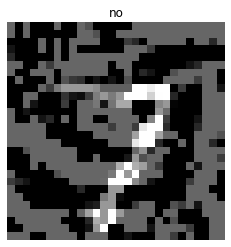

In [6]:
import matplotlib.pyplot as plt
# Load the required model
mnist_model = tf.keras.models.load_model("/ssd-sata1/mwt/def_project/DiffRobOT/MNIST/LeNet5_MNIST_normal.h5")

# Calculate total perturbation (in L2 norm)
perturbation = np.linalg.norm(adv_image - test_image)
total_perturbation = np.linalg.norm(perturbation)

# Get original label
original_label = np.argmax(mnist_model.predict(np.expand_dims(test_image, axis = 0)))
# original_label = np.argmax(mnist_model_logits.predict(np.expand_dims(test_image, axis=0)))

# Get adversarial label
adv_label = np.argmax(mnist_model.predict(adv_image))
# adv_label = np.argmax(mnist_model_logits.predict(adv_image))

# Output results
print(f"Original Label: {original_label}")
print(f"Adversarial Label: {adv_label}")
print(f"Total Perturbation (L2 norm): {total_perturbation}")
print(f"Total Iterations: {10}")  # The number of iterations is specified by `nb_iter`

# Convert the adversarial image back to numpy for visualization if needed
adv_image_np = adv_image.numpy().squeeze()  # Remove batch and channel dimensions
print(f"Adversarial Image: {adv_image_np}")

plt.axis('off')
plt.title("no")
plt.imshow(adv_image_np, cmap=plt.cm.gray)